## Multiple Layer Perceptron 
Neurons that wire together, fire together.
- Interesting Links:
  * [Tensorflow Playground](canva.cn/design/DAGg2x5dSYg/VIfjFxANLJGp337xR_56vw/edit?ui=eyJEIjp7IlAiOnsiQiI6ZmFsc2V9fX0)
  * If you want to make life easier when reading in MNIST, you can try it in CVS version.

    [train_train_imagesset for trainning](http://www.pjreddie.com/media/files/mnist_train.csv)

    [train_train_imagesset for testing](http://www.pjreddie.com/media/files/mnist_test.csv)
  * [Yes you should understand backprop -- Andrej Karpathy](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)
  * https://dezeming.top/wp-content/uploads/2023/07/%E5%8F%8D%E5%90%91%E4%BC%A0%E6%92%ADBackPropagation%E8%AF%A6%E7%BB%86%E6%8E%A8%E5%AF%BC%E6%95%99%E7%A8%8B.pdf

#### Get the Lib Done

In [1]:
import numpy as np
import struct
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox

#### Get the train_train_images Done

In [8]:
# Get the train_train_images done
def load_images(filename):
    filepath = "./datasets/MNIST/"
    with open(os.path.join(filepath, filename), 'rb') as f:
        magic_number, num, rows, cols = struct.unpack(">IIII", f.read(16))
        train_train_images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return train_train_images

def load_labels(filename):
    filepath = "./datasets/MNIST"
    with open(os.path.join(filepath, filename), 'rb') as f:
        # If you don't want these unnecessary variables
        # Use "f.read(8)" to move forward the file pointer
        magic_number, num = struct.unpack(">II", f.read(8))
        label = np.frombuffer(f.read(), dtype=np.uint8)
    return label

def one_hot(labels):
    one_hot = np.zeros((labels.size, 10, 1))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

train_images = load_images("train-images.idx3-ubyte").reshape((60000, 784, 1))
train_labels = load_labels("train-labels.idx1-ubyte")

test_images = load_images("t10k-images.idx3-ubyte").reshape((10000, 784)).T
test_labels = load_labels("t10k-labels.idx1-ubyte")

train_labels = one_hot(train_labels)
test_labels = one_hot(test_labels).reshape((-1, 10)).T

#### Get the Model Done

In [9]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # 防止溢出
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[1]  # batch_size
    loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
    return loss

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = []
        self.biases = []

        for i in range(len(self.layers) - 1):
            W = np.random.randn(self.layers[i + 1], self.layers[i]) * np.sqrt(1/layers[i])
            self.weights.append(W)
            bias = np.random.randn(self.layers[i + 1], 1)
            self.biases.append(bias)
    
    def feedforward(self, images):
        self.activations = [images] 
        self.zs = []            

        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(W, self.activations[-1]) + b
            self.zs.append(z)
            if i == len(self.weights) - 1:
                self.activations.append(softmax(z))
            else:
                self.activations.append(sigmoid(z))
        return self.activations[-1]


    def backpropagation(self, labels):
        batch_size = labels.shape[1]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]

        error = self.activations[-1] - labels
        nabla_b[-1] = np.mean(error, axis=1, keepdims=True)
        nabla_w[-1] = np.dot(error, self.activations[-2].T) / batch_size

        for l in range(2, len(self.layers)):
            z = self.zs[-l]
            error = np.dot(self.weights[-l+1].T, error) * d_sigmoid(z)
            nabla_b[-l] = np.mean(error, axis=1, keepdims=True)
            nabla_w[-l] = np.dot(error, self.activations[-l-1].T) / batch_size

        return (nabla_w, nabla_b)
    
    def update(self, nabla_w, nabla_b, learning_rate):
        self.weights = [w - (learning_rate) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (learning_rate) * nb for b, nb in zip(self.biases, nabla_b)]

    def train(self, train_images, train_labels, test_images, test_labels, epochs, batch_size, lr):
        history = {'loss':[], 'accuracy':[]}
        for epoch in range(epochs):
            permutation = np.random.permutation(train_images.shape[0])
            shuffled_images = train_images[permutation]
            shuffled_labels = train_labels[permutation]

            epoch_loss = 0
            for i in range(0, len(shuffled_images), batch_size):
                batch_images_sliced = shuffled_images[i:i+batch_size]
                batch_labels_sliced = shuffled_labels[i:i+batch_size]
                
                current_batch_size = batch_images_sliced.shape[0]
                
                batch_images = batch_images_sliced.reshape(current_batch_size, -1).T
                batch_labels = batch_labels_sliced.reshape(current_batch_size, -1).T

                output_labels = self.feedforward(batch_images)
                
                epoch_loss += cross_entropy_loss(output_labels, batch_labels)

                nabla_w, nabla_b = self.backpropagation(batch_labels)
                self.update(nabla_w, nabla_b, lr)
            
            avg_loss = epoch_loss / (train_images.shape[0] / batch_size)
            history['loss'].append(avg_loss)
            
            val_output = self.feedforward(test_images)
            accuracy = np.mean(np.argmax(val_output, axis=0) == np.argmax(test_labels, axis=0))
            history['accuracy'].append(accuracy)

            clear_output(wait=True)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}")
        
        return history


#### Get the Training Done

Epoch 30/30 - Loss: 0.1831 - Accuracy: 0.9443


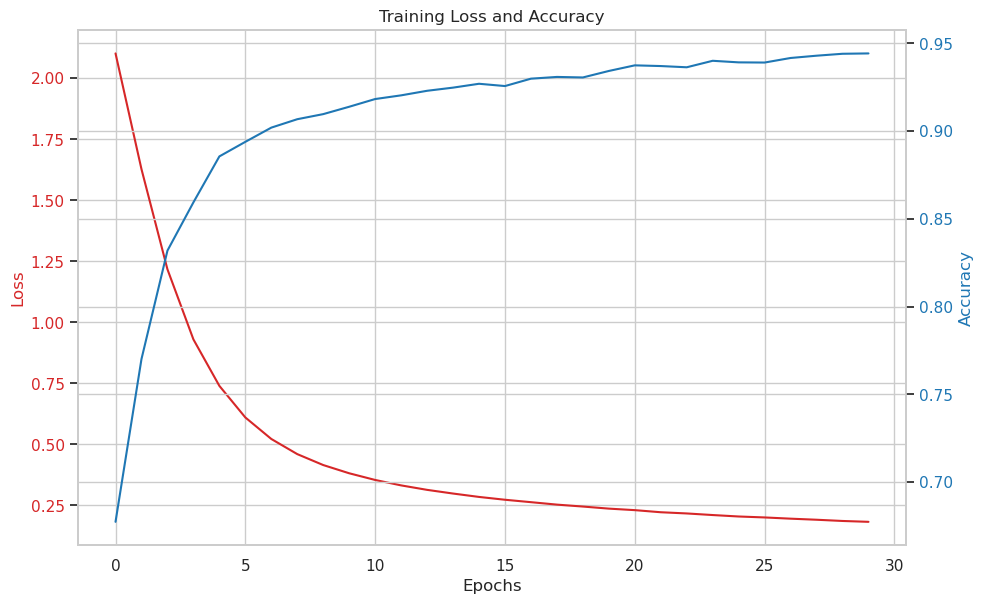

In [10]:
# --- 训练和可视化的代码块 ---
nn = NeuralNetwork([784, 128, 64, 10])

history = nn.train(train_images, train_labels, 
                   test_images, test_labels,
                   epochs=30, batch_size=128, lr=0.01)

import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制损失曲线
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history['loss'], color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# 创建第二个 y 轴来绘制准确率曲线
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(history['accuracy'], color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Accuracy')
plt.show()

#### More Visualization

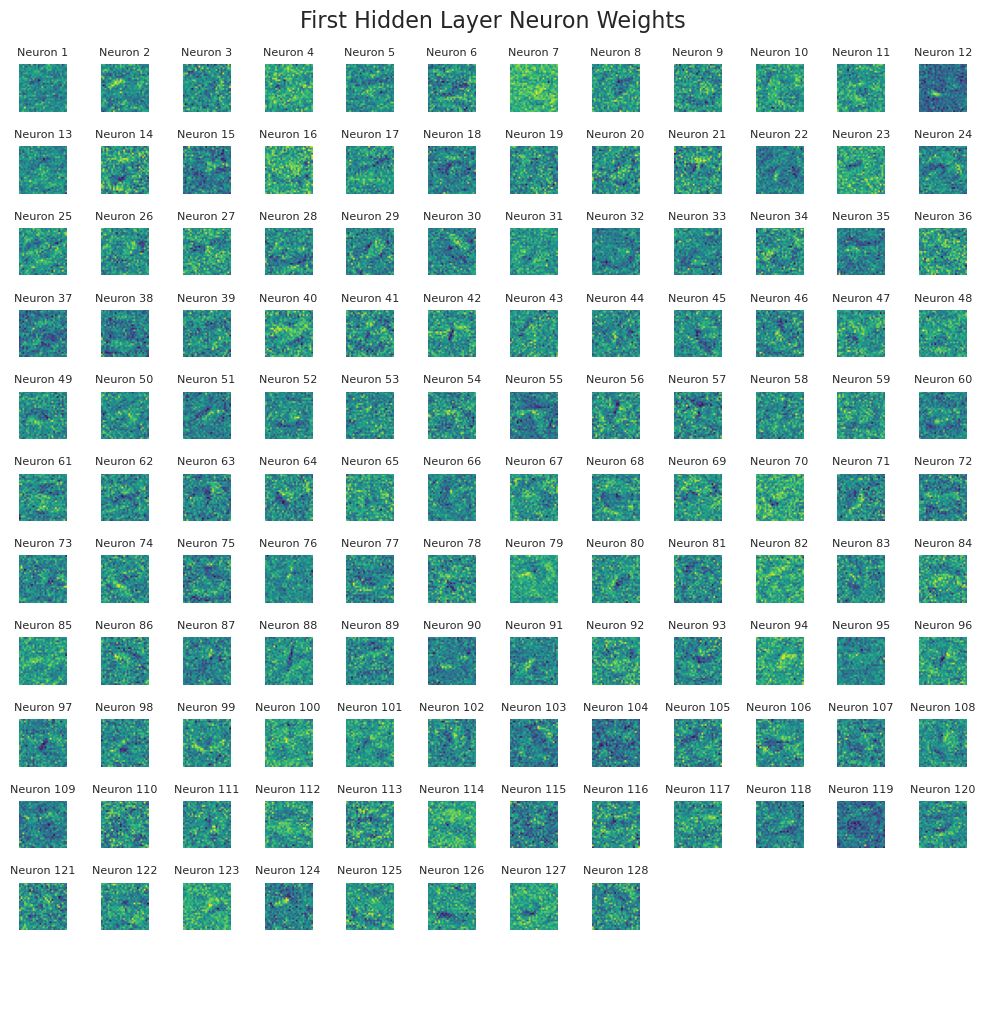

In [12]:
def visualize_first_layer_weights(nn_model):
    # 获取第一层的权重矩阵 (hidden_neurons, 784)
    first_layer_weights = nn_model.weights[0]
    
    # 获取权重的形状
    num_neurons, num_inputs = first_layer_weights.shape
    
    # 计算需要多少行和列来显示所有神经元
    side_len = int(np.ceil(np.sqrt(num_neurons)))
    
    fig, axes = plt.subplots(side_len, side_len, figsize=(10, 10))
    # 将二维的 axes 数组扁平化，方便迭代
    axes = axes.flatten()

    for i in range(num_neurons):
        # 提取第 i 个神经元的权重，并重塑为 28x28 图像
        neuron_weights = first_layer_weights[i].reshape(28, 28)
        
        # 在子图中显示权重图像
        ax = axes[i]
        im = ax.imshow(neuron_weights, cmap='viridis') # viridis 色彩图效果很好
        ax.set_title(f"Neuron {i+1}", fontsize=8)
        ax.axis('off')
        
    # 隐藏多余的子图
    for i in range(num_neurons, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.suptitle("First Hidden Layer Neuron Weights", fontsize=16, y=1.02)
    plt.show()

# 调用函数进行可视化
visualize_first_layer_weights(nn)

# Just For Fun

In [ ]:
# 读入数据
with open("./train_train_imagessets/MNIST/train-train_train_images.idx3-ubyte", 'rb') as f:
    magic_number, num, rows, cols = struct.unpack(">IIII", f.read(16))
    print(f"magic number = {magic_number}\nnum = {num}\nrows = {rows}\ncols = {cols}")

In [ ]:
test_train_train_images = load_images("train-train_train_images.idx3-ubyte")
plt.imshow(test_train_train_images[0], cmap='gray')
plt.show()

test_labels = load_labels("train-labels.idx1-ubyte")
print(test_labels[0])

In [ ]:
out = nn.feedforward(test_train_train_images[1])
plt.imshow(test_train_train_images[1].reshape((28, 28)), cmap="gray")
print(out)